<h1>1. Imports & Warnings</h1>

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')


<h1>2. Generate Synthetic Dataset (3000 records)</h1>

In [31]:
# Fix seed for reproducibility
np.random.seed(42)

# Number of records
n = 3000
outlook_choices = ['sunny', 'overcast', 'rainy']

# Create synthetic dataset
data = {
    'outlook': np.random.choice(outlook_choices, n),
    'temperature': np.random.randint(60, 100, n),  # between 60°F and 100°F
    'humidity': np.random.randint(50, 100, n),     # between 50% and 100%
    'windy': np.random.choice([True, False], n)
}

df = pd.DataFrame(data)

# Rules to determine target variable
def decide_play(row):
    if row['outlook'] == 'overcast':
        return 'yes'
    elif row['outlook'] == 'sunny':
        return 'no' if row['humidity'] > 75 else 'yes'
    elif row['outlook'] == 'rainy':
        return 'no' if row['windy'] else 'yes'

df['play_tennis'] = df.apply(decide_play, axis=1)

print("Synthetic Tennis Dataset (first 10 rows):")
print(df.head(10))
print("\nDataset shape:", df.shape)


Synthetic Tennis Dataset (first 10 rows):
    outlook  temperature  humidity  windy play_tennis
0     rainy           89        75  False         yes
1     sunny           81        95  False          no
2     rainy           87        63   True          no
3     rainy           66        94  False         yes
4     sunny           94        93   True          no
5     sunny           87        73   True         yes
6     rainy           73        90   True          no
7  overcast           69        50  False         yes
8     rainy           75        92  False         yes
9     rainy           75        71  False         yes

Dataset shape: (3000, 5)


<h1>3. Preprocessing (Encoding + Scaling)</h1>

In [32]:
# Encode categorical features
label_encoders = {}
for col in ['outlook', 'windy', 'play_tennis']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Features and target
X = df[['outlook', 'temperature', 'humidity', 'windy']]
y = df['play_tennis']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train[['temperature', 'humidity']] = scaler.fit_transform(X_train[['temperature', 'humidity']])
X_test[['temperature', 'humidity']] = scaler.transform(X_test[['temperature', 'humidity']])


<h1>4. Train the Naive Bayes Model</h1>

In [33]:
# Train model
model = GaussianNB()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


<h1>5. Model Evaluation</h1>


Model Accuracy: 82.17%

Classification Report:
              precision    recall  f1-score   support

          no       0.76      0.62      0.68       186
         yes       0.84      0.91      0.88       414

    accuracy                           0.82       600
   macro avg       0.80      0.77      0.78       600
weighted avg       0.82      0.82      0.82       600

Confusion Matrix:


[[116  70]
 [ 37 377]]


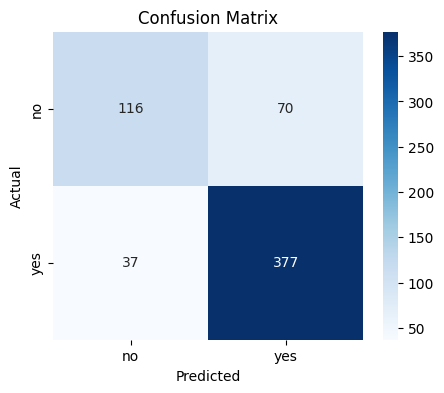

In [34]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nModel Accuracy: {:.2f}%".format(accuracy * 100))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoders['play_tennis'].classes_))


# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoders['play_tennis'].classes_,
            yticklabels=label_encoders['play_tennis'].classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



<h1> Feature Importance </h1>

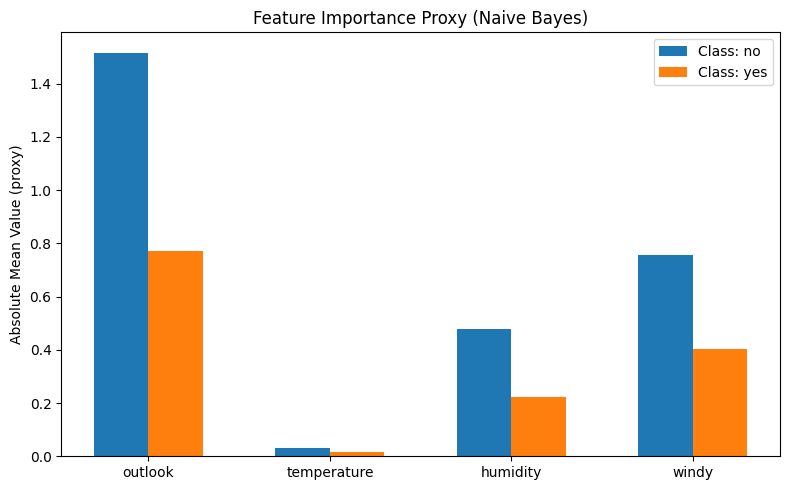

In [40]:
# Plot feature importance (proxy: absolute mean values per class)
import numpy as np

feature_names = ['outlook', 'temperature', 'humidity', 'windy']
class_names = label_encoders['play_tennis'].classes_

plt.figure(figsize=(8,5))
for i, class_label in enumerate(class_names):
    plt.bar(np.arange(len(feature_names)) + i*0.3, 
            np.abs(model.theta_[i]), 
            width=0.3, 
            label=f'Class: {class_label}')

plt.xticks(np.arange(len(feature_names)) + 0.3/2, feature_names)
plt.ylabel('Absolute Mean Value (proxy)')
plt.title('Feature Importance Proxy (Naive Bayes)')
plt.legend()
plt.tight_layout()
plt.show()

<h1>6. Save & Load Model</h1>

In [35]:
# Save model and scaler
joblib.dump(model, "model/tennis_model.joblib")
joblib.dump(scaler, "model/scaler.joblib")
joblib.dump(label_encoders, "model/label_encoders.joblib")

# Load them back
loaded_model = joblib.load("model/tennis_model.joblib")
loaded_scaler = joblib.load("model/scaler.joblib")
loaded_encoders = joblib.load("model/label_encoders.joblib")


In [36]:
df.head()

,outlook,temperature,humidity,windy,play_tennis
0,1,89,75,0,1
1,2,81,95,0,0
2,1,87,63,1,0
3,1,66,94,0,1
4,2,94,93,1,0


<h1>7. Make Predictions on New Data</h1>

In [38]:
# Test new cases
test_cases = [
    ('sunny', 75, 70, True),     
    ('overcast', 68, 65, False),  
    ('rainy', 65, 95, False),     
    ('sunny', 85, 85, False),     
]

# Convert test cases to DataFrame
df_test = pd.DataFrame(test_cases, columns=['outlook', 'temperature', 'humidity', 'windy'])

# Encode categorical features
for col in ['outlook', 'windy']:
    df_test[col] = loaded_encoders[col].transform(df_test[col])

# Scale numerical features
df_test[['temperature', 'humidity']] = loaded_scaler.transform(df_test[['temperature', 'humidity']])

# Predict
predictions = loaded_model.predict(df_test)
df_test['Prediction'] = loaded_encoders['play_tennis'].inverse_transform(predictions)

print("\nPredictions on Test Cases:")
print(df_test)



Predictions on Test Cases:
   outlook  temperature  humidity  windy Prediction
0        2    -0.418277 -0.312757      1         no
1        0    -1.034144 -0.661718      0        yes
2        1    -1.298087  1.432051      0        yes
3        2     0.461534  0.734128      0        yes


In [39]:
# Test new cases
test_cases = [
    ('sunny', 75, 70, True),     
    ('overcast', 68, 65, False),  
    ('rainy', 65, 95, False),     
    ('sunny', 85, 85, False),     
]

# Keep original input for display
df_test_original = pd.DataFrame(test_cases, columns=['outlook', 'temperature', 'humidity', 'windy'])

# Encode categorical features
df_test = df_test_original.copy()
for col in ['outlook', 'windy']:
    df_test[col] = loaded_encoders[col].transform(df_test[col])

# Scale numerical features
df_test[['temperature', 'humidity']] = loaded_scaler.transform(df_test[['temperature', 'humidity']])

# Predict
predictions = loaded_model.predict(df_test)
df_test_original['Prediction'] = loaded_encoders['play_tennis'].inverse_transform(predictions)

print("\nPredictions on Test Cases (with original input):")
print(df_test_original)


Predictions on Test Cases (with original input):
    outlook  temperature  humidity  windy Prediction
0     sunny           75        70   True         no
1  overcast           68        65  False        yes
2     rainy           65        95  False        yes
3     sunny           85        85  False        yes
